Ignacio Vellido Expósito

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Haberman's Survival Data Set

https://archive.ics.uci.edu/ml/datasets/haberman's+survival

## Data Set Information:

The dataset contains cases from a study that was conducted between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer.


## Attribute Information:

1. Age of patient at time of operation (numerical)
2. Patient's year of operation (year - 1900, numerical)
3. Number of positive axillary nodes detected (numerical)
4. Survival status (class attribute)
  - 1 = the patient survived 5 years or longer
  - 2 = the patient died within 5 year

In [1]:
################################################################################
# Libraries
################################################################################

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import layers
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Import the metrics from `sklearn.metrics`
from sklearn.metrics import (confusion_matrix, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            cohen_kappa_score)

################################################################################

# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
################################################################################
# Load data
################################################################################

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tsc/haberman.dat', 
                 names=["Age", "Year", "Nodes", "Survival"])
df.Survival = df.Survival.astype("category").cat.codes.astype("category")

df

,Age,Year,Nodes,Survival
0,38,59,2,0
1,39,63,4,0
2,49,62,1,0
3,53,60,2,0
4,47,68,4,0
...,...,...,...,...
301,57,64,1,1
302,63,62,0,0
303,42,61,4,0
304,43,64,2,0


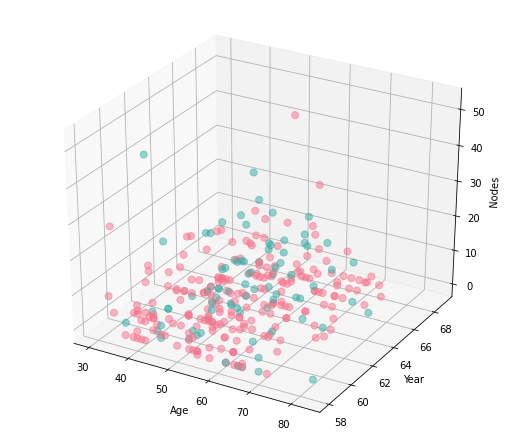

In [ ]:
################################################################################
# Visualize data
################################################################################

# https://stackoverflow.com/questions/52285104/3d-scatterplots-in-python-with-hue-colormap-and-legend

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(7,6))
ax = Axes3D(fig)

cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())

# Plot
sc = ax.scatter(df.Age, df.Year, df.Nodes, c=df.Survival, marker='o', cmap=cmap, s=50, alpha=.5)
ax.set_xlabel('Age')
ax.set_ylabel('Year')
ax.set_zlabel('Nodes')

plt.show()

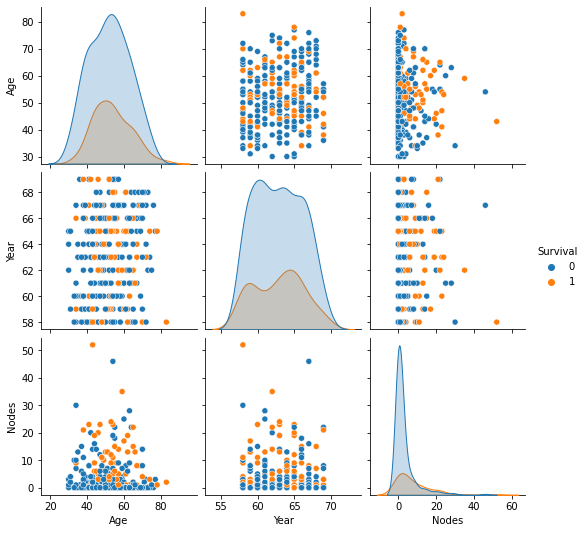

In [ ]:
sns.pairplot(df, hue="Survival")

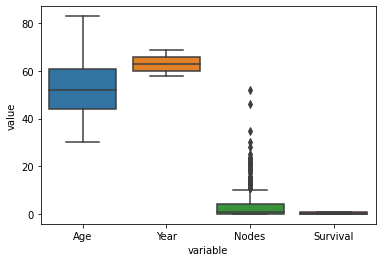

In [4]:
sns.boxplot(x="variable", y="value", data=pd.melt(df))

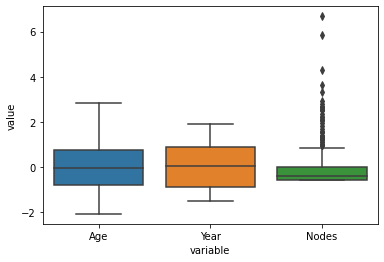

In [5]:
# Scaled boxplot
scaled = StandardScaler().fit_transform(df.drop(columns="Survival"))
scaled = pd.DataFrame(scaled, columns=["Age", "Year", "Nodes"])

sns.boxplot(x="variable", y="value", data=pd.melt(scaled))

In [ ]:
df.describe()

,Age,Year,Nodes
count,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144
std,10.803452,3.249405,7.189654
min,30.000000,58.000000,0.000000
25%,44.000000,60.000000,0.000000
50%,52.000000,63.000000,1.000000
75%,60.750000,65.750000,4.000000
max,83.000000,69.000000,52.000000


In [ ]:
df.Survival.describe()

count     306
unique      2
top         0
freq      225
Name: Survival, dtype: int64

In [ ]:
print("Instancias duplicadas: {}".format(len(df) - len(df.drop_duplicates())))

# Null values
nulls = df.isnull().sum(axis=1).tolist()
print("Valores nulos: {}".format(len([x for x in nulls if x > 0])))

Instancias duplicadas: 17
Valores nulos: 0


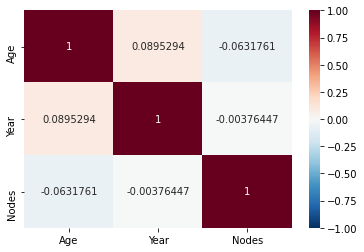

In [ ]:
corr = df.corr()
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap='RdBu_r',
            annot=True, fmt="g",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Conclusiones:
- Problema no separable linealmente.
- Etiquetas desbalanceadas (~76% para la clase "negative"). Tenemos como baseline a superar un modelo que consigue un 0.76 de accuracy.
- Instancias duplicadas pero ninguna nula. Por la semántica del problema pueden pertenecer a pacientes diferentes.
- Cierta normalidad para la variable Age, el resto cláramente no siguen distribuciones normales.
- No contamos con correlación alguna entre las variables.

In [ ]:
################################################################################
# Train-test split
################################################################################

y = df.Survival
x = df.drop(columns="Survival")

# Split the data up in train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    stratify=y, # Because we have imbalanced data
                                                    test_size=0.2)

Contamos con muy pocos datos, por lo que reducimos el tamaño de test al mínimo.
Vamos a modelar el modelo en base al conjunto de validación, por lo que no será un gran problema.

Para tener un conjunto de test significativo, necesitamos forzar a que el balanceo de clases siga presente en él.

In [ ]:
################################################################################
# Preprocessing data
################################################################################

# Define the scaler 
scaler = StandardScaler().fit(x_train)

# Scale the train set
x_train = scaler.transform(x_train)

# Scale the test set
x_test = scaler.transform(x_test)

In [ ]:
# Oversampling minority class with SMOTE

from imblearn.over_sampling import SMOTE

old_x_train, old_y_train = x_train, y_train

oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

pd.DataFrame(x_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,0,1,2
0,-0.359376,-0.287832,-0.417300
1,-0.549176,-0.287832,-0.550226
2,-0.738977,1.265951,-0.550226
3,-1.118577,1.265951,-0.550226
4,-0.074676,0.022925,-0.018522
...,...,...,...
353,-1.093427,1.072507,-0.500046
354,0.068213,1.653516,0.248837
355,0.160968,0.344206,0.178616
356,-0.883539,0.333681,-0.170038


In [ ]:
# Setting initial bias
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
from keras.initializers import Constant

pos = np.count_nonzero(y.to_numpy())
neg = len(y) - pos

bias = np.log([pos/neg])

output_bias = tf.keras.initializers.Constant(output_bias)

bias

array([-1.02165125])

In [ ]:
# Finding class weights

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = neg + pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.89


In [ ]:
################################################################################
# Define model
################################################################################

input_shape = x.shape

# Initialize the constructor
model = Sequential(
    [
      Dense(8, activation='relu', input_shape=(3,)),
      Dense(4, activation='relu'),
      # Dropout(0.25),
      # Dense(2, activation='relu'),
      Dense(1, activation='sigmoid', 
            # bias_initializer=output_bias
            )
    ]
)

# Model summary
print(model.summary())

################################################################################
# Fit model
################################################################################

# Parameters
batch_size = 1
epochs = 50
lr = 1e-4

opt = Adam(lr=lr)

# Compile model
# model.compile(optimizer=opt,
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_callback = EarlyStopping(monitor='accuracy', 
                               patience=3,
                               restore_best_weights=True)

history = model.fit(x_train, 
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[early_callback], 
                    # class_weight=class_weight,               
                    verbose=1)


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 8)                 32        
_________________________________________________________________
dense_90 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
195/195 [==============================] - 1s 2ms/step - loss: 0.7209 - accuracy: 0.4034 - val_loss: 0.6786 - val_accuracy: 0.6327
Epoch 2/50
195/195 [==============================] - 0s 1ms/step - loss: 0.6691 - accuracy: 0.7312 - val_loss: 0.6606 - val_accuracy: 0.6939
Epoch 3/50
195/195 [==============================] - 0s 1ms/step - loss: 0.6541 - accuracy: 0.717

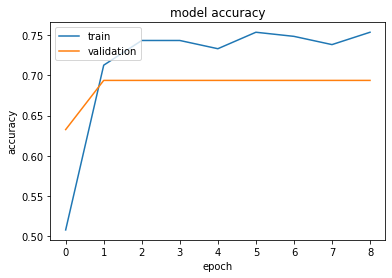

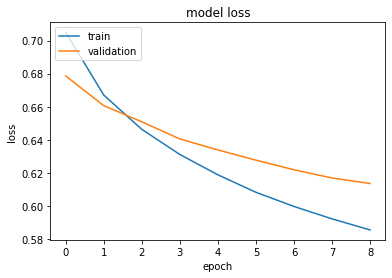

In [ ]:
# Plot training history

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
################################################################################
# Test model
################################################################################

print("Evaluate model: ")
loss, accuracy = model.evaluate(x_test, y_test)

predictions = model.predict(x_test)
y_pred = (predictions>0.5)

print("\nLoss:      {} \nAccuracy:  {}".format(loss, accuracy))

# Precision 
print("Precision: {}".format(precision_score(y_test, y_pred)))

# Recall
print("Recall:    {}".format(recall_score(y_test, y_pred)))

# F1 score
print("F1 score:  {}".format(f1_score(y_test,y_pred)))

# Cohen's kappa
print("Kappa:     {}".format(cohen_kappa_score(y_test, y_pred)))

# Confusion matrix
labels = list(range(0,2))
conf = confusion_matrix(y_test, y_pred, labels=labels)
df_cm = pd.DataFrame(conf, index=labels, columns=labels)
df_cm

Evaluate model: 
2/2 [==============================] - 0s 5ms/step - loss: 0.6498 - accuracy: 0.6613

Loss:      0.6497843265533447 
Accuracy:  0.6612903475761414
Precision: 0.4074074074074074
Recall:    0.6875
F1 score:  0.5116279069767441
Kappa:     0.27746947835738067


,0,1
0,30,16
1,5,11


## Mejor modelo sin oversampling de dos capas:
8 y 4 unidades

- Loss: 0.5147305130958557 
- Accuracy: 0.774193525314331
- Precision: 0.625
- Recall:    0.3125
- F1 score:  0.4166666666666667
- Kappa:     0.2954545454545454

| _0|_1

0	43	3

1	11	5

## Mejor modelo con oversampling de dos capas:
8 y 8 unidades

- Loss: 0.5504443049430847 
- Accuracy: 0.774193525314331
- Precision: 0.5714285714285714
- Recall:    0.5
- F1 score:  0.5333333333333333
- Kappa:     0.3852691218130312

| _0|_1

0	40	6

1	8	8

## Mejor modelo de dos capas con bias inicial:
12 y 8 unidades

- Loss:      0.5794850587844849 
- Accuracy:  0.7419354915618896
- Precision: 0.5
- Recall:    0.5625
- F1 score:  0.5294117647058824
- Kappa:     0.3524804177545692

| _0|_1

0	37	9

1	7	9

## Mejor modelo de dos capas con pesos intra-clase
12 y 8 unidades

- Loss:      0.6497843265533447 
- Accuracy:  0.6612903475761414
- Precision: 0.4074074074074074
- Recall:    0.6875
- F1 score:  0.5116279069767441
- Kappa:     0.27746947835738067

| _0|_1

0	30	16

1	5	11

# Conclusiones:
- Es importante ajustar el learning rate (y en algunos casos el decay) del optimizador para posponer un poco el comienzo del sobreajuste. En algunos casos se realiza overfitting tras el primer backpropagation volviendo difícil la modelización de la arquitectura.
- Tenemos muy pocos datos, por lo que se intenta reducir el tamaño del modelo al mínimo. Se juega más con los parámetros de entrenamiento y las particiones para evitar el sobreajuste.
- En accuracy se consigue superar ligeramente al modelo baseline, pero debemos cuestionarnos cuál sería la meta a alcanzar en este problema. Si el objetivo es conseguir el mayor porcentaje de aciertos, es probable que se pueda ajustar aún mejor una arquitectura con oversampling para alcanzar al menos un 80% de precisión.
- Si por el contrario quisieramos reducir al mínimo la predicción de supervivencia cuando no se de, una combinación de arquitectura con pesos intra-clase inicializándola con un buen bias inicial sería la opción a seguir. Hemos visto que los resultados de recall para estos métodos son mejores, y es en lo que estaríamos interesados en este caso (siempre que no sea a costa de mucha precisión).
- Aún así deberíamos tener en cuenta que pueden existir otras técnicas de oversampling que den mejores resultados que SMOTE en este caso.